In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd 

import random

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
import zipfile
from pathlib import Path

data_path = Path('MURA-v1.1/')

if not data_path.exists():
    data_path.mkdir()

with zipfile.ZipFile('MURA-v1.1.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print('Data extracted')

Data extracted


In [6]:
train_df = pd.read_csv(data_path/'train_image_paths.csv', header=None, names=['FilePath'])
valid_df = pd.read_csv(data_path/'valid_image_paths.csv', header=None, names=['FilePath'])
trainlabels_df = pd.read_csv(data_path/'train_labeled_studies.csv', header=None, names=['FilePath', 'Label'])
validlabels_df = pd.read_csv(data_path/'valid_labeled_studies.csv', header=None, names=['FilePath', 'Label'])

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = Image.open(img_name).convert('L')
        label = 1 if 'positive' in img_name else 0
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224])
])



In [8]:
def get_study_data(study_type):
    train_studies = trainlabels_df[trainlabels_df['FilePath'].str.contains(study_type)]
    valid_studies = validlabels_df[validlabels_df['FilePath'].str.contains(study_type)]
    
    train_study_df = train_df[train_df['FilePath'].isin(train_studies['FilePath'])]
    valid_study_df = valid_df[valid_df['FilePath'].isin(valid_studies['FilePath'])]

    trainlabels_study_df = trainlabels_df[trainlabels_df['FilePath'].isin(train_studies['FilePath'])]
    validlabels_study_df = validlabels_df[validlabels_df['FilePath'].isin(valid_studies['FilePath'])]
    train_dataset = Dataset(train_study_df, transform=train_transform)
    valid_dataset = Dataset(valid_study_df, transform=valid_transform)
    
    return train_study_df, valid_study_df, trainlabels_study_df, validlabels_study_df

In [9]:
study_types = ['XR_WRIST', 'XR_HUMERUS', 'XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_SHOULDER']
study_train_df, study_valid_df, train_dataset, valid_dataset, train_dataloader, valid_dataloader = {}, {}, {}, {}, {}, {}

for study_type in study_types:
    study_train_df[study_type] = train_df[train_df['FilePath'].str.contains(study_type)]
    study_valid_df[study_type] = valid_df[valid_df['FilePath'].str.contains(study_type)]

    train_dataset[study_type] = Dataset(study_train_df[study_type], transform=train_transform)
    valid_dataset[study_type] = Dataset(study_valid_df[study_type], transform=valid_transform)

    train_dataloader[study_type] = DataLoader(train_dataset[study_type], batch_size=8, shuffle=True)
    valid_dataloader[study_type] = DataLoader(valid_dataset[study_type], batch_size=8, shuffle=False)

In [10]:
for study_type in study_types:
    print(f'{study_type}: {len(train_dataset[study_type])} training images and {len(valid_dataset[study_type])} validation images')
    for batch in train_dataloader[study_type]:
        print(batch[0].shape, batch[1].shape)
        break

XR_WRIST: 9752 training images and 659 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_HUMERUS: 1272 training images and 288 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_ELBOW: 4931 training images and 465 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_FINGER: 5106 training images and 461 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_FOREARM: 1825 training images and 301 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_HAND: 5543 training images and 460 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_SHOULDER: 8379 training images and 563 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])


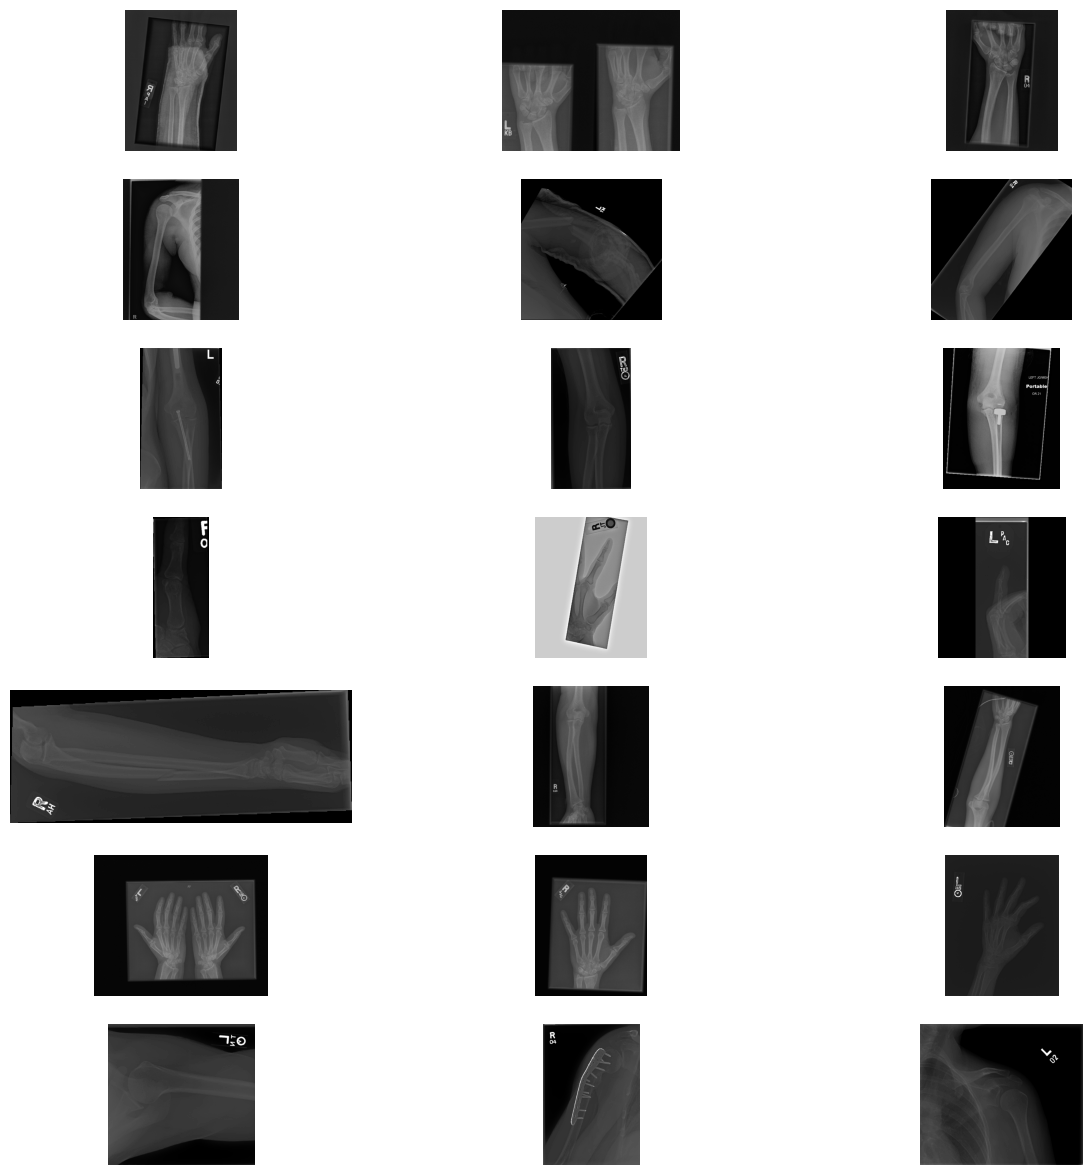

In [11]:
num_images = 3
fig, axs = plt.subplots(7, 3, figsize=(15, 15))
# Get random indices

for study_type in study_types:
    indices = random.sample(range(len(study_train_df[study_type])), num_images)
    for i, idx in enumerate(indices):
        img_path = study_train_df[study_type].iloc[idx]['FilePath']
        img = plt.imread(img_path)
        row = study_types.index(study_type)
        col = i
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].axis('off')

# Show the plot
plt.show()

In [12]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        "Bottleneck function"
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features
    
    
class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)
    
    
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [13]:
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained DenseNet121 model
model = models.densenet121(pretrained=True)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.to(device)

from torchinfo import summary
summary(model, input_size=(8, 1, 224, 224))

/home/abhavvohra/anaconda3/envs/torch01/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhavvohra/anaconda3/envs/torch01/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [8, 1000]                 --
├─Sequential: 1-1                        [8, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [8, 64, 112, 112]         3,136
│    └─BatchNorm2d: 2-2                  [8, 64, 112, 112]         128
│    └─ReLU: 2-3                         [8, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [8, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [8, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [8, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [8, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [8, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [8, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [8, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [8, 32, 56, 56]     

In [14]:
def train(model, train_dataloader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output[:, 0]
        target = target.float()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step() 
    return loss.item()

In [15]:
def validate(model, val_dataloader, criterion):
    model.eval()
    val_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output[:, 0]
            target = target.float()
            loss = criterion(output, target)
            val_loss += loss.item()
            predicted = (output >= 0.5).float()  
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_loss /= len(val_dataloader)
    accuracy = (correct / total) * 100
    return val_loss, accuracy


Epoch 1/15, Training Loss: 0.3032, Validation Loss: 0.5397, Validation Accuracy: 78.6039
Epoch 2/15, Training Loss: 0.1658, Validation Loss: 0.4730, Validation Accuracy: 78.3005
Epoch 3/15, Training Loss: 0.4900, Validation Loss: 0.4467, Validation Accuracy: 80.2731
Epoch 4/15, Training Loss: 0.1626, Validation Loss: 0.4608, Validation Accuracy: 81.9423
Epoch 5/15, Training Loss: 0.9148, Validation Loss: 0.4146, Validation Accuracy: 81.9423
Epoch 6/15, Training Loss: 0.4765, Validation Loss: 0.4193, Validation Accuracy: 82.2458
Epoch 7/15, Training Loss: 0.1530, Validation Loss: 0.4027, Validation Accuracy: 83.7633
Epoch 8/15, Training Loss: 0.1806, Validation Loss: 0.3886, Validation Accuracy: 83.4598
Epoch 9/15, Training Loss: 0.7425, Validation Loss: 0.4033, Validation Accuracy: 84.0668
Epoch 10/15, Training Loss: 0.1377, Validation Loss: 0.4320, Validation Accuracy: 83.1563
Epoch 11/15, Training Loss: 0.1180, Validation Loss: 0.4225, Validation Accuracy: 83.7633
Epoch 12/15, Traini

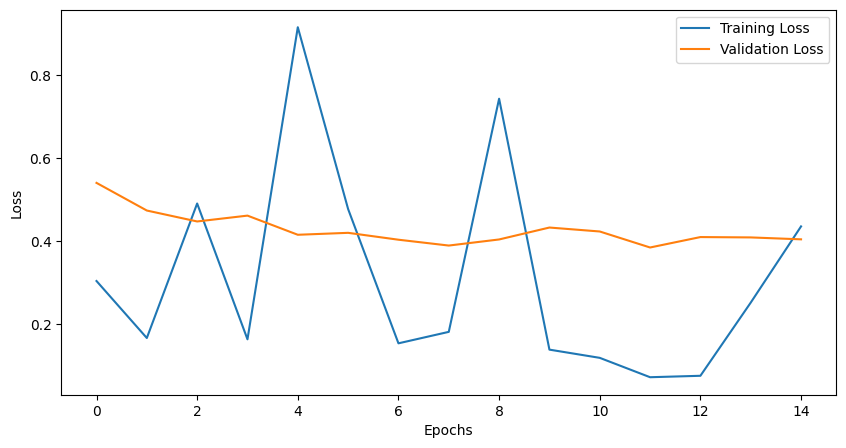

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 15

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[0]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

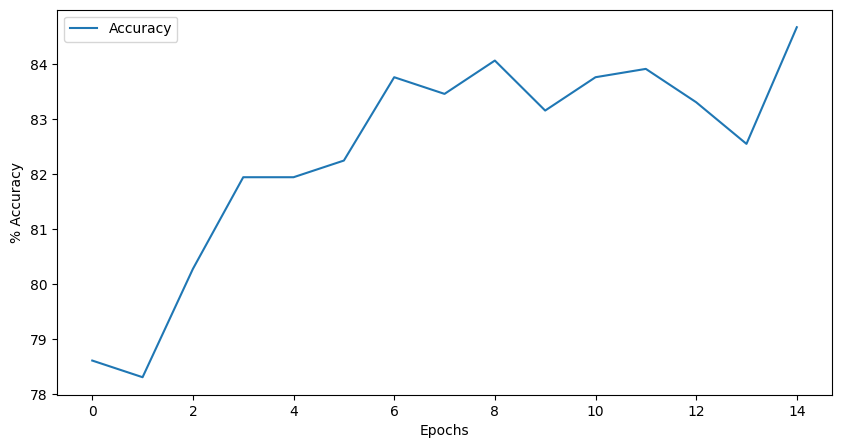

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

Epoch 1/10, Training Loss: 0.9663, Validation Loss: 0.6457, Validation Accuracy: 50.3254
Epoch 2/10, Training Loss: 0.2890, Validation Loss: 0.7012, Validation Accuracy: 48.1562
Epoch 3/10, Training Loss: 0.5236, Validation Loss: 1.1490, Validation Accuracy: 55.3145
Epoch 4/10, Training Loss: 0.4412, Validation Loss: 0.6690, Validation Accuracy: 57.0499
Epoch 5/10, Training Loss: 1.1666, Validation Loss: 0.6173, Validation Accuracy: 60.3037
Epoch 6/10, Training Loss: 0.7997, Validation Loss: 1.0673, Validation Accuracy: 52.4946
Epoch 7/10, Training Loss: 0.6431, Validation Loss: 2.6661, Validation Accuracy: 44.2516
Epoch 8/10, Training Loss: 1.0018, Validation Loss: 0.6207, Validation Accuracy: 56.1822
Epoch 9/10, Training Loss: 1.0330, Validation Loss: 0.6668, Validation Accuracy: 61.3883
Epoch 10/10, Training Loss: 0.7481, Validation Loss: 0.6005, Validation Accuracy: 64.8590


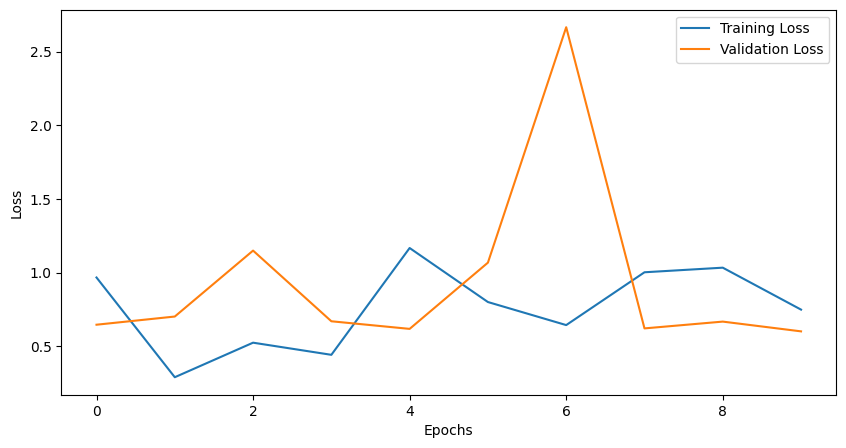

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[1]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

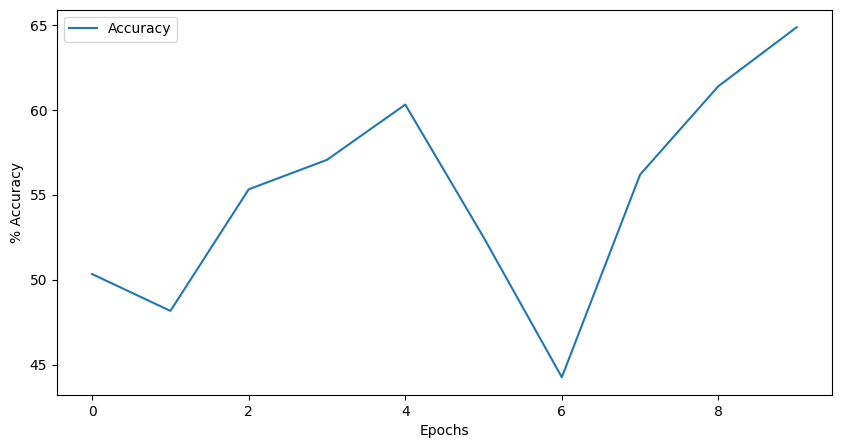

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

Epoch 1/10, Training Loss: 0.4586, Validation Loss: 0.6214, Validation Accuracy: 63.1229
Epoch 2/10, Training Loss: 0.3930, Validation Loss: 0.6191, Validation Accuracy: 65.7807
Epoch 3/10, Training Loss: 0.4252, Validation Loss: 0.6321, Validation Accuracy: 64.4518
Epoch 4/10, Training Loss: 0.3911, Validation Loss: 0.6335, Validation Accuracy: 63.1229
Epoch 5/10, Training Loss: 0.3886, Validation Loss: 0.6419, Validation Accuracy: 65.7807
Epoch 6/10, Training Loss: 0.4329, Validation Loss: 0.6463, Validation Accuracy: 65.4485
Epoch 7/10, Training Loss: 0.3358, Validation Loss: 0.6374, Validation Accuracy: 65.7807
Epoch 8/10, Training Loss: 0.5572, Validation Loss: 0.5381, Validation Accuracy: 68.4385
Epoch 9/10, Training Loss: 0.2836, Validation Loss: 0.5557, Validation Accuracy: 67.4419
Epoch 10/10, Training Loss: 1.1649, Validation Loss: 0.5898, Validation Accuracy: 67.1096


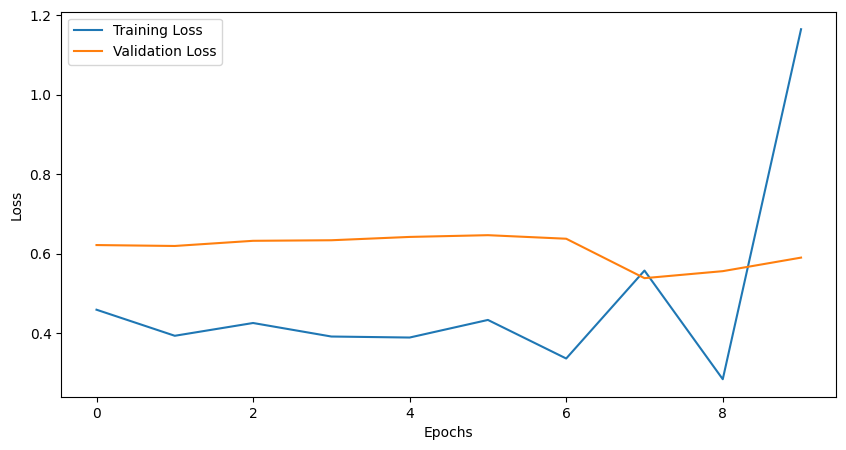

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[2]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

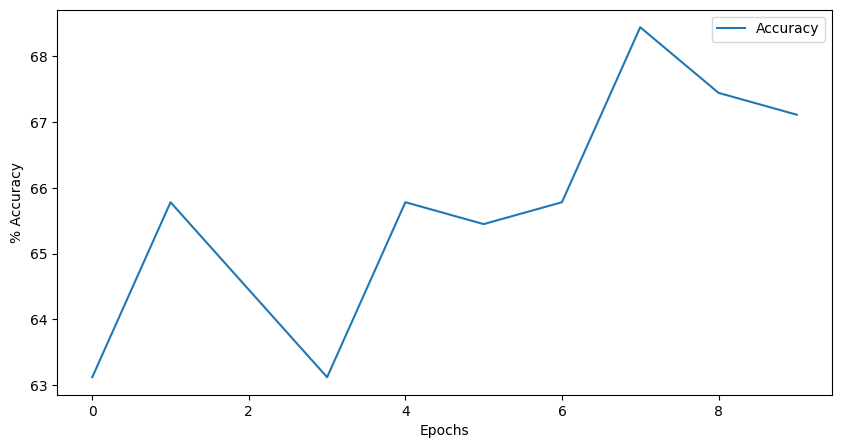

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

Epoch 1/20, Training Loss: 0.6055, Validation Loss: 0.4891, Validation Accuracy: 76.0417
Epoch 2/20, Training Loss: 0.6766, Validation Loss: 0.5019, Validation Accuracy: 74.6528
Epoch 3/20, Training Loss: 0.3887, Validation Loss: 0.4865, Validation Accuracy: 76.7361
Epoch 4/20, Training Loss: 0.5753, Validation Loss: 0.4860, Validation Accuracy: 76.7361
Epoch 5/20, Training Loss: 0.6713, Validation Loss: 0.4915, Validation Accuracy: 73.9583
Epoch 6/20, Training Loss: 0.5072, Validation Loss: 0.4784, Validation Accuracy: 75.3472
Epoch 7/20, Training Loss: 0.7625, Validation Loss: 0.4593, Validation Accuracy: 77.7778
Epoch 8/20, Training Loss: 0.5973, Validation Loss: 0.4383, Validation Accuracy: 79.8611
Epoch 9/20, Training Loss: 0.6626, Validation Loss: 0.4551, Validation Accuracy: 78.4722
Epoch 10/20, Training Loss: 0.9471, Validation Loss: 0.4500, Validation Accuracy: 80.2083
Epoch 11/20, Training Loss: 0.5951, Validation Loss: 0.4574, Validation Accuracy: 77.4306
Epoch 12/20, Traini

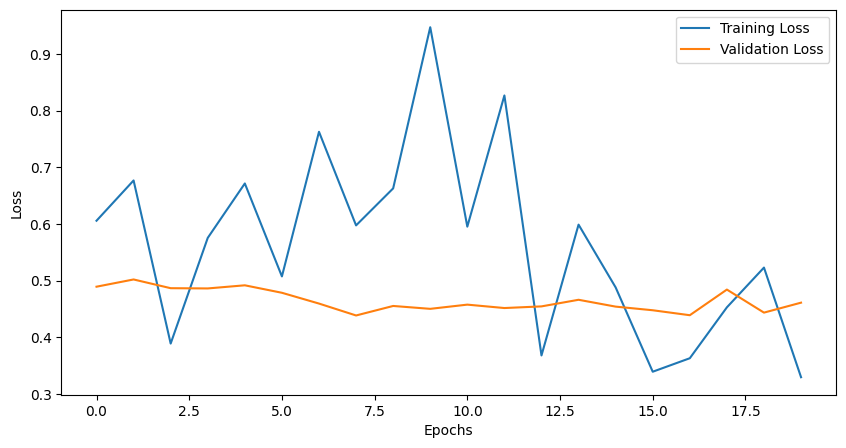

In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[4]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

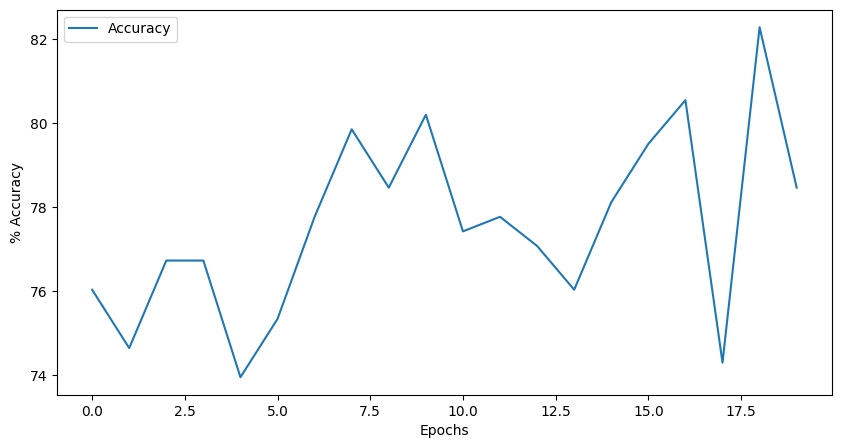

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

Epoch 1/5, Training Loss: 0.5459, Validation Loss: 0.6236, Validation Accuracy: 61.9565
Epoch 2/5, Training Loss: 0.4419, Validation Loss: 0.6045, Validation Accuracy: 63.6957
Epoch 3/5, Training Loss: 0.4792, Validation Loss: 0.6289, Validation Accuracy: 64.5652
Epoch 4/5, Training Loss: 0.5732, Validation Loss: 0.6247, Validation Accuracy: 67.6087
Epoch 5/5, Training Loss: 0.4908, Validation Loss: 0.5818, Validation Accuracy: 64.3478


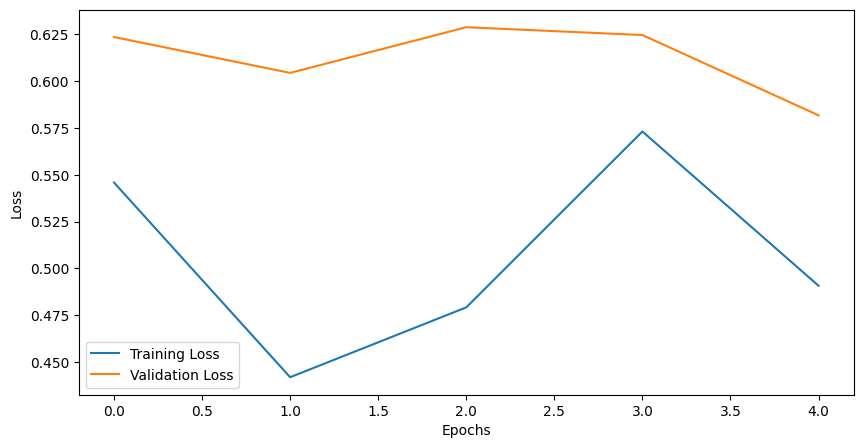

In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[3]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

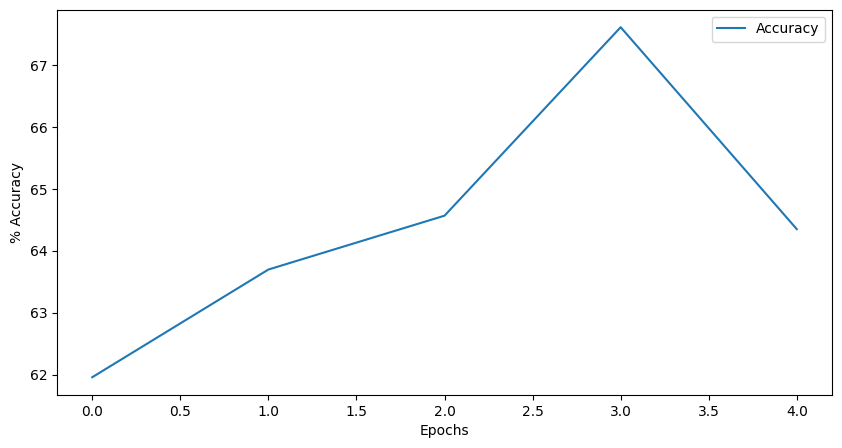

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

In [27]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[5]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[6]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()